## Results Analysis

### EC Number Classification

In [19]:
import pytorch_lightning as pl
from src.pl_models import PlEGNNModel,EGNNDataModule
import torch
trainer = pl.Trainer(max_epochs=100, accelerator="gpu")
model=PlEGNNModel(num_layers=4, emb_dim=64, in_dim=31, edge_dim=32, out_dim=384, num_classes=384)
datamodule = EGNNDataModule(flex = None, num_workers = 1, without_fold=0, num_folds=3,store_data="./data/preprocessed_data",batch_size=64, labels_dir="./data/enzyme_data/")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
trainer.test(model, ckpt_path=".\Cross_Checkpoints\EC\\no_flex_without_fold_2-epoch=77-val_macro_f1=0.47.ckpt", datamodule = datamodule)

100%|██████████| 8759/8759 [00:52<00:00, 165.91it/s]
Restoring states from the checkpoint path at .\Cross_Checkpoints\EC\no_flex_without_fold_2-epoch=77-val_macro_f1=0.47.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at .\Cross_Checkpoints\EC\no_flex_without_fold_2-epoch=77-val_macro_f1=0.47.ckpt
C:\Users\Mihailo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    2.6329903602600098     │
│       test_macro_f1       │    0.46302855014801025    │
│      test_micro_acc       │    0.6311222910881042     │
└───────────────────────────┴───────────────────────────┘

[{'test_macro_f1': 0.46302855014801025,
  'test_micro_acc': 0.6311222910881042,
  'test_loss': 2.6329903602600098}]

In [84]:
# Obtained from above
no_flex_f1 = [0.4630, 0.4687, 0.4575]
msqf_5_f1 = [0.4670, 0.4523, 0.4495]

d = [no_flex_f1[i]-msqf_5_f1[i] for i in range(3)]*100
d_hat = (sum(d))/3
d_hat

0.6799999999999996

In [85]:
import math
s_d = math.sqrt(sum([(d[i]-d_hat)*(d[i]-d_hat)/6 for i in range(3)]))
s_d

0.47606108851700923

In [86]:
t = d_hat/s_d
t
# We can reject with 90% confidence, which means that no flex is better

1.4283881132110292

In [93]:
import pytorch_lightning as pl
from src.pl_models import PlEGNNModel,EGNNDataModule
import torch

trainer = pl.Trainer(max_epochs=100, accelerator="gpu")
model = PlEGNNModel(num_layers=4, emb_dim=64, in_dim=31, edge_dim=32, out_dim=384, num_classes=384)
datamodule = EGNNDataModule(flex = None, num_workers = 1, without_fold=0, num_folds=3,store_data="./data/preprocessed_data",batch_size=64, labels_dir="./data/enzyme_data/")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [94]:
datamodule.setup("test")
test_data = datamodule.test_dataset

100%|██████████| 8759/8759 [00:53<00:00, 165.26it/s]


In [95]:
loaded_model = PlEGNNModel.load_from_checkpoint(".\Cross_Checkpoints\EC\\no_flex_without_fold_2-epoch=77-val_macro_f1=0.47.ckpt")

In [97]:
from src.experiment_utils import eval_metrics, eval_corr

res1 = eval_metrics(loaded_model, test_data)
corr1 = eval_corr(loaded_model, test_data, num_classes=384)

100%|██████████| 8759/8759 [06:54<00:00, 21.13it/s]


In [98]:
loaded_model2 = PlEGNNModel.load_from_checkpoint(".\Cross_Checkpoints\EC\\no_flex_without_fold_1-epoch=85-val_macro_f1=0.49.ckpt")

In [99]:
from src.experiment_utils import eval_metrics

res2 = eval_metrics(loaded_model2, test_data)
corr2 = eval_corr(loaded_model2, test_data, num_classes=384)

100%|██████████| 8759/8759 [06:58<00:00, 20.94it/s]


In [100]:
loaded_model3 = PlEGNNModel.load_from_checkpoint(".\Cross_Checkpoints\EC\\no_flex_without_fold_0-epoch=83-val_macro_f1=0.49.ckpt")

In [101]:
from src.experiment_utils import eval_metrics

res3 = eval_metrics(loaded_model3, test_data)
corr3 = eval_corr(loaded_model3, test_data, num_classes=384)

100%|██████████| 8759/8759 [06:56<00:00, 21.01it/s]


In [120]:
no_corr = [[(corr1[i][j]+corr2[i][j]+corr3[i][j])/3 for i in range(384)] for j in range(384)]

In [116]:
with open("./data/enzyme_data/unique_functions.txt", "r") as f:
    ec_layer = [int(line.strip()[0]) for line in f.readlines()]

In [122]:
ec_no_corr = [[0 for i in range(7)] for j in range(7)]

for i in range(384):
    for j in range(384):
        ec_no_corr[ec_layer[i]-1][ec_layer[j]-1] += no_corr[i][j]

[Text(0.5, 23.52222222222222, 'Predicted Top-Level EC'),
 Text(50.722222222222214, 0.5, 'Actual Top-Level EC'),
 Text(0.5, 1.0, 'Model Without Dynamics')]

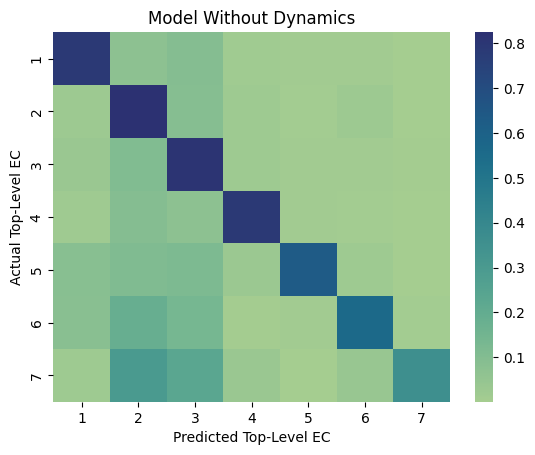

In [166]:
from matplotlib import pyplot as plt
import seaborn as sns

no = list(map(list, zip(*ec_no_corr)))
no = [[no[j][i]/sum(no[j]) for i in range(7)] for j in range(7)]

ax = sns.heatmap(no, cmap="crest",fmt='.0f', xticklabels=range(1,8),yticklabels=range(1,8))
ax.set(xlabel="Predicted Top-Level EC", ylabel="Actual Top-Level EC", title="Model Without Dynamics")


In [108]:
f1_scores = []
f1_scores.append([res1[0][i]/(res1[0][i] + (res1[2][i]+res1[3][i])/2) for i in range(384)])
f1_scores.append([res2[0][i]/(res2[0][i] + (res2[2][i]+res2[3][i])/2) for i in range(384)])
f1_scores.append([res3[0][i]/(res3[0][i] + (res3[2][i]+res3[3][i])/2) for i in range(384)])

res = [(f1_scores[0][i]+f1_scores[1][i]+f1_scores[2][i])/3 for i in range(384)]

zeros = []
ones = []
middle = []

for i in range(384):
    if res[i]<=0.2:
        zeros.append(i)
    elif res[i]>=0.8:
        ones.append(i)
    else:
        middle.append(i)

print(len(zeros))
print(len(ones))
print(len(middle))

95
56
233


In [109]:
# open file in write mode
with open(r'./zeros.txt', 'w') as fp:
    for item in zeros:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')
    # open file in write mode
with open(r'./ones.txt', 'w') as fp:
    for item in ones:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')
    # open file in write mode
with open(r'./middle.txt', 'w') as fp:
    for item in middle:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done
Done
Done


In [2]:
%load_ext autoreload
%autoreload 2

In [141]:
import pytorch_lightning as pl
from src.pl_models import PlEGNNModel,EGNNDataModule
import torch
from src.experiment_utils import eval_metrics

trainer = pl.Trainer(max_epochs=100, accelerator="gpu")
model_init = PlEGNNModel(num_layers=4, emb_dim=64, in_dim=32, edge_dim=32, out_dim=384, num_classes=384)
datamodule = EGNNDataModule(flex = "msqf", num_workers = 1, without_fold=0, num_folds=3,store_data="./data/preprocessed_data/5",batch_size=64, labels_dir="./data/enzyme_data/")

datamodule.setup("test")
test_data = datamodule.test_dataset

paths = [r".\Cross_Checkpoints\EC\msqf_k_5_without_fold_0-epoch=101-val_macro_f1=0.47.ckpt",
         r".\Cross_Checkpoints\EC\msqf_k_5_without_fold_1-epoch=133-val_macro_f1=0.47.ckpt",
         r".\Cross_Checkpoints\EC\msqf_k_5_without_fold_2-epoch=183-val_macro_f1=0.48.ckpt"]

results = []
corr = []

for path in paths:
    model = PlEGNNModel(num_layers=4, emb_dim=64, in_dim=32, edge_dim=32, out_dim=384, num_classes=384).load_from_checkpoint(path)
    results.append(eval_metrics(model, test_data))
    corr.append(eval_corr(model, test_data, num_classes=384))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
100%|██████████| 8759/8759 [07:10<00:00, 20.33it/s]


In [142]:
with_corr = [[(corr[0][i][j]+corr[1][i][j]+corr[2][i][j])/3 for i in range(384)] for j in range(384)]

In [143]:
ec_with_corr = [[0 for i in range(7)] for j in range(7)]

for i in range(384):
    for j in range(384):
        ec_with_corr[ec_layer[i]-1][ec_layer[j]-1] += with_corr[i][j]

[Text(50.722222222222214, 0.5, 'Actual Top-Level EC'),
 Text(0.5, 23.52222222222222, 'Predicted Top-Level EC'),
 Text(0.5, 1.0, 'Model With Dynamics')]

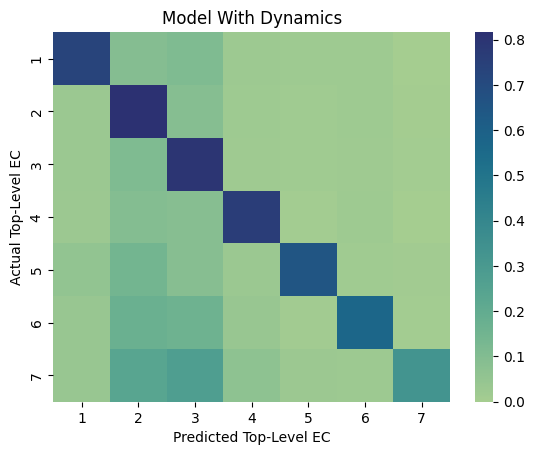

In [167]:
from matplotlib import pyplot as plt
import seaborn as sns

yes = list(map(list, zip(*ec_with_corr)))

yes = [[yes[j][i]/sum(yes[j]) for i in range(7)] for j in range(7)]

ax = sns.heatmap(yes, cmap="crest",fmt='.0f', xticklabels=range(1,8),yticklabels=range(1,8))
ax.set(ylabel="Actual Top-Level EC", xlabel="Predicted Top-Level EC", title="Model With Dynamics")


[Text(50.722222222222214, 0.5, 'Predicted Top-Level EC'),
 Text(0.5, 23.52222222222222, 'Actual Top-Level EC'),
 Text(0.5, 1.0, 'Model With Dynamics')]

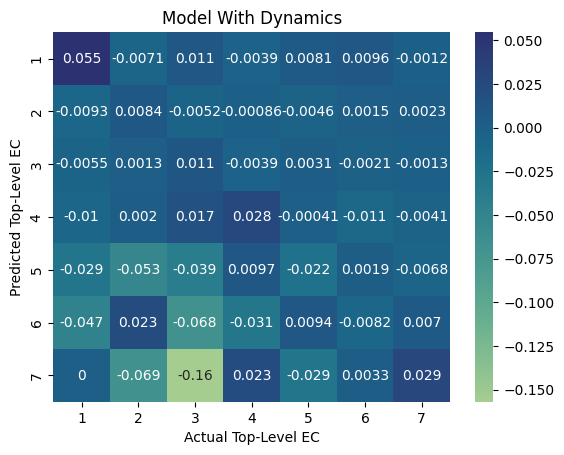

In [159]:
from matplotlib import pyplot as plt
import seaborn as sns

no = list(map(list, zip(*ec_no_corr)))
yes = list(map(list, zip(*ec_with_corr)))

diff = [[no[i][j]/sum(no[j])-yes[i][j]/sum(yes[j]) for i in range(7)] for j in range(7)]

ax = sns.heatmap(diff, annot=True, cmap="crest", xticklabels=range(1,8),yticklabels=range(1,8))
ax.set(ylabel="Predicted Top-Level EC", xlabel="Actual Top-Level EC", title="Model With Dynamics")


In [129]:
f1_scores = []
f1_scores.append([results[0][0][i]/(results[0][0][i] + (results[0][2][i]+results[0][3][i])/2) for i in range(384)])
f1_scores.append([results[1][0][i]/(results[1][0][i] + (results[1][2][i]+results[1][3][i])/2) for i in range(384)])
f1_scores.append([results[2][0][i]/(results[2][0][i] + (results[2][2][i]+results[2][3][i])/2) for i in range(384)])

res = [(f1_scores[0][i]+f1_scores[1][i]+f1_scores[2][i])/3 for i in range(384)]

zeros = []
ones = []
middle = []

for i in range(384):
    if res[i]<=0.2:
        zeros.append(i)
    elif res[i]>=0.8:
        ones.append(i)
    else:
        middle.append(i)

print(len(zeros))
print(len(ones))
print(len(middle))
zeros_dynamics = zeros
ones_dynamics = ones
middle_dynamics = middle

100
61
223


In [130]:
# open file in write mode
with open(r'./zeros_dynamics.txt', 'w') as fp:
    for item in zeros_dynamics:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')
    # open file in write mode
with open(r'./ones_dynamics.txt', 'w') as fp:
    for item in ones_dynamics:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')
    # open file in write mode
with open(r'./middle_dynamics.txt', 'w') as fp:
    for item in middle_dynamics:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done
Done
Done


In [131]:
# empty list to read list from a file
zeros = []
ones = []
middle = []

# open file and read the content in a list
with open(r'.\zeros.txt', 'r') as fp:
    for line in fp:
        # remove linebreak from a current name
        # linebreak is the last character of each line
        x = int(line[:-1])

        # add current item to the list
        zeros.append(x)
# open file and read the content in a list
with open(r'.\ones.txt', 'r') as fp:
    for line in fp:
        # remove linebreak from a current name
        # linebreak is the last character of each line
        x = int(line[:-1])

        # add current item to the list
        ones.append(x)
# open file and read the content in a list
with open(r'.\middle.txt', 'r') as fp:
    for line in fp:
        # remove linebreak from a current name
        # linebreak is the last character of each line
        x = int(line[:-1])

        # add current item to the list
        middle.append(x)

In [133]:
def difference(list1, list2):
    res = [i for i in list1 if i in list2]
    return len(res)

corr = [[difference(zeros,zeros_dynamics), difference(zeros,middle_dynamics), difference(zeros,ones_dynamics)],
        [difference(middle,zeros_dynamics), difference(middle,middle_dynamics), difference(middle,ones_dynamics)],
        [difference(ones,zeros_dynamics), difference(ones,middle_dynamics), difference(ones,ones_dynamics)]]

corr

[[73, 22, 0], [27, 177, 29], [0, 24, 32]]

[Text(0.5, 23.52222222222222, 'Model With Dynamics'),
 Text(50.72222222222221, 0.5, 'Model Without Dynamcis')]

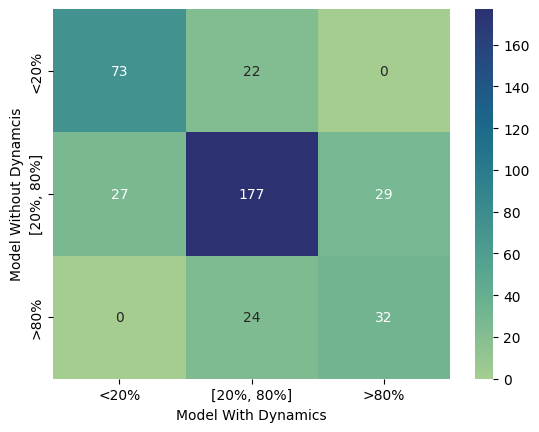

In [134]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.heatmap(corr, annot=True, cmap="crest",fmt='.0f', xticklabels=["<20%","[20%, 80%]", ">80%"], yticklabels=["<20%","[20%, 80%]", ">80%"])
ax.set(xlabel="Model With Dynamics", ylabel="Model Without Dynamcis")

### Motion Domain Classification

In [47]:
import pytorch_lightning as pl
from src.pl_models import PlEGNNModel,EGNNDataModule
import torch
trainer = pl.Trainer(max_epochs=100, accelerator="gpu")
model=PlEGNNModel(num_layers=4, emb_dim=64, in_dim=31, edge_dim=32, out_dim=6, num_classes=6)
datamodule = EGNNDataModule(flex = None, num_workers = 1, without_fold=0, num_folds=4,store_data="./data/preprocessed_data_md",batch_size=4, labels_dir="./data/domain_data/")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [51]:
trainer.test(model, ckpt_path=".\Cross_Checkpoints\MD\\no_flex_without_fold_3-epoch=21-val_macro_f1=1.00.ckpt", datamodule = datamodule)

100%|██████████| 57/57 [00:00<00:00, 712.25it/s]
Restoring states from the checkpoint path at .\Cross_Checkpoints\MD\no_flex_without_fold_3-epoch=21-val_macro_f1=1.00.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at .\Cross_Checkpoints\MD\no_flex_without_fold_3-epoch=21-val_macro_f1=1.00.ckpt
C:\Users\Mihailo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.9242316484451294     │
│       test_macro_f1       │    0.7479058504104614     │
│      test_micro_acc       │    0.8070175647735596     │
└───────────────────────────┴───────────────────────────┘

[{'test_macro_f1': 0.7479058504104614,
  'test_micro_acc': 0.8070175647735596,
  'test_loss': 0.9242316484451294}]

In [87]:
# Taken from W&B logs
no_flex_f1 = [0.8048, 0.7828, 0.7620, 0.7479]
msqf_5_f1 = [0.7878, 0.7828, 0.7452, 0.8058]

d = [no_flex_f1[i]-msqf_5_f1[i] for i in range(4)]*100
d_hat = (sum(d))/4
d_hat

-0.6025000000000023

In [88]:
import math
s_d = math.sqrt(sum([(d[i]-d_hat)*(d[i]-d_hat)/12 for i in range(4)]))
s_d

0.34483186120195

In [89]:
t = d_hat/s_d
t
# We can reject with 90% confidence, which means that no flex is better

-1.7472283387617409

In [3]:
import pytorch_lightning as pl
from src.pl_models import PlEGNNModel,EGNNDataModule
import torch
from src.experiment_utils import eval_metrics, eval_corr

trainer = pl.Trainer(max_epochs=100, accelerator="gpu")
datamodule = EGNNDataModule(flex = "msqf", num_workers = 1, without_fold=0, num_folds=4,store_data="./data/preprocessed_data_md/5",batch_size=4, labels_dir="./data/domain_data/")

datamodule.setup("test")
test_data = datamodule.test_dataset

paths = [r".\Cross_Checkpoints\MD\msqf_k_5_without_fold_0-epoch=20-val_macro_f1=0.98.ckpt",
         r".\Cross_Checkpoints\MD\msqf_k_5_without_fold_1-epoch=27-val_macro_f1=0.99.ckpt",
         r".\Cross_Checkpoints\MD\msqf_k_5_without_fold_2-epoch=32-val_macro_f1=0.94.ckpt",
         r".\Cross_Checkpoints\MD\msqf_k_5_without_fold_3-epoch=24-val_macro_f1=1.00.ckpt"]

with_results = []
with_corr = [[0 for i in range(6)] for j in range(6)]

for path in paths:
    model = PlEGNNModel(num_layers=4, emb_dim=64, in_dim=32, edge_dim=32, out_dim=6, num_classes=6).load_from_checkpoint(path)
    with_results.append(eval_metrics(model, test_data, num_classes=6))
    update = eval_corr(model, test_data, num_classes=6)
    with_corr = [[with_corr[i][j] + update[i][j] for i in range(6)] for j in range(6)]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
100%|██████████| 57/57 [00:03<00:00, 15.97it/s]


In [4]:
with_help = [0, 0, 0, 0, 0, 0]

for res in with_results:
    with_help = [with_help[i] + (res[0][i]/(res[0][i]+(res[2][i]+res[3][i])/2))/4 for i in range(6)]

<BarContainer object of 6 artists>

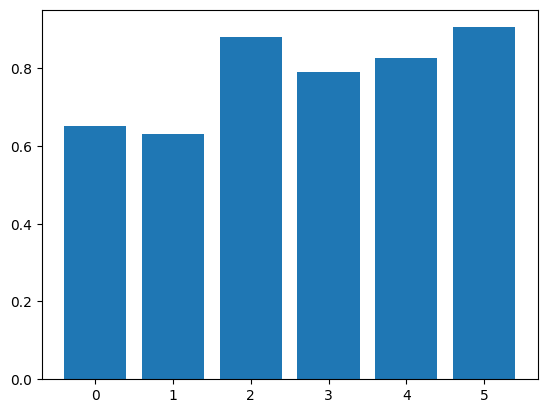

In [5]:
from matplotlib import pyplot as plt

plt.bar(range(6), with_help)

In [7]:
import pytorch_lightning as pl
from src.pl_models import PlEGNNModel,EGNNDataModule
import torch
from src.experiment_utils import eval_metrics

trainer = pl.Trainer(max_epochs=100, accelerator="gpu")
datamodule = EGNNDataModule(flex = None , num_workers = 1, without_fold=0, num_folds=4,store_data="./data/preprocessed_data_md",batch_size=4, labels_dir="./data/domain_data/")

datamodule.setup("test")
test_data = datamodule.test_dataset

paths = [r".\Cross_Checkpoints\MD\no_flex_without_fold_0-epoch=51-val_macro_f1=0.94.ckpt",
         r".\Cross_Checkpoints\MD\no_flex_without_fold_1-epoch=29-val_macro_f1=0.97.ckpt",
         r".\Cross_Checkpoints\MD\no_flex_without_fold_2-epoch=37-val_macro_f1=0.99.ckpt",
         r".\Cross_Checkpoints\MD\no_flex_without_fold_3-epoch=21-val_macro_f1=1.00.ckpt"]

no_results = []
no_corr = [[0 for i in range(6)] for j in range(6)]

for path in paths:
    model = PlEGNNModel(num_layers=4, emb_dim=64, in_dim=31, edge_dim=32, out_dim=6, num_classes=6).load_from_checkpoint(path)
    no_results.append(eval_metrics(model, test_data, num_classes=6))
    update = eval_corr(model, test_data, num_classes=6)
    no_corr = [[no_corr[i][j] + update[i][j] for i in range(6)] for j in range(6)]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
100%|██████████| 57/57 [00:03<00:00, 16.20it/s]


In [8]:
no_help = [0, 0, 0, 0, 0, 0]

for res in no_results:
    no_help = [no_help[i] + (res[0][i]/(res[0][i]+(res[2][i]+res[3][i])/2))/4 for i in range(6)]

<BarContainer object of 6 artists>

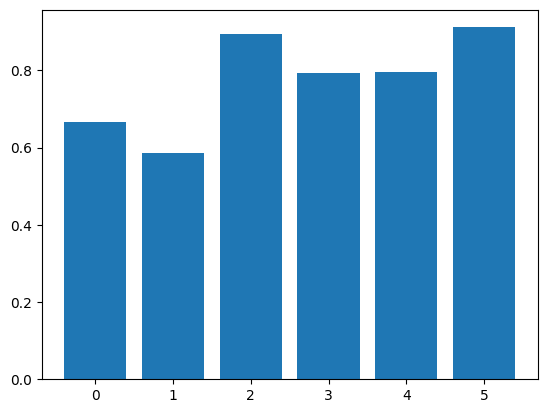

In [9]:
from matplotlib import pyplot as plt

plt.bar(range(6), no_help)

<Figure size 640x480 with 0 Axes>

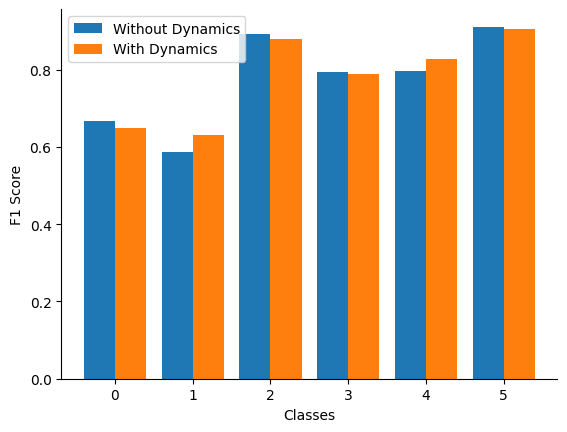

In [10]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.despine()

X = ["coupled_domain_motion", "independent_domain_motion", "independent_local_motion", "burying_ligand_motion", "coupled_local_motion", "no_significant_motion"]
X_axis = np.arange(6)

fig, ax = plt.subplots()

ax.bar(X_axis - 0.2, no_help, 0.4, label = 'Without Dynamics')
ax.bar(X_axis + 0.2, with_help, 0.4, label = 'With Dynamics')

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.xticks(X_axis, [0,1,2,3,4,5])
plt.xlabel("Classes")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

[Text(0.5, 23.52222222222222, 'Predicted Class'),
 Text(50.722222222222214, 0.5, 'Actual Class'),
 Text(0.5, 1.0, 'Model With Dynamics')]

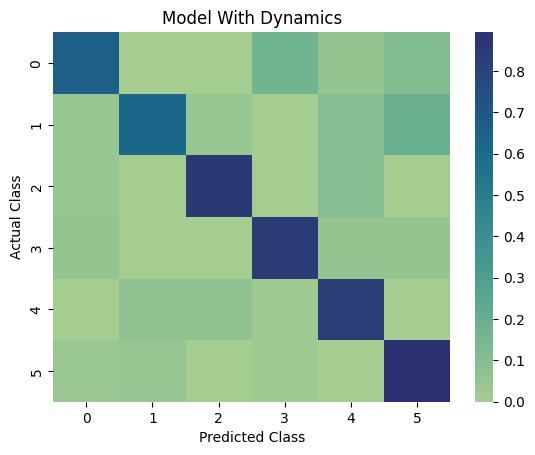

In [18]:
import seaborn as sns

yes = [[with_corr[j][i]/sum(with_corr[j]) for i in range(6)] for j in range(6)]

ax = sns.heatmap(yes, cmap="crest")
ax.set(xlabel="Predicted Class", ylabel="Actual Class", title= "Model With Dynamics")


[Text(0.5, 23.52222222222222, 'Predicted Class'),
 Text(50.722222222222214, 0.5, 'Actual Class'),
 Text(0.5, 1.0, 'Model Without Dynamics')]

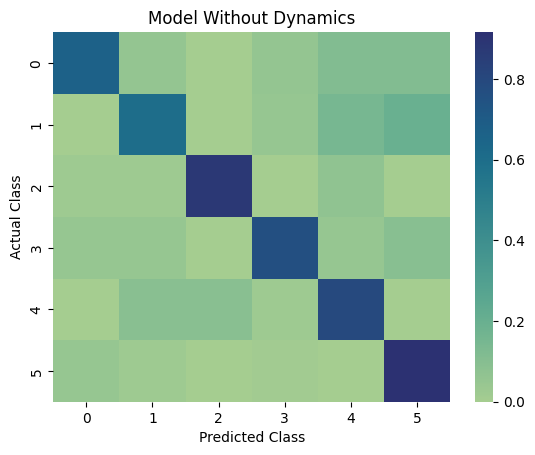

In [19]:
import seaborn as sns

no = [[no_corr[j][i]/sum(no_corr[j]) for i in range(6)] for j in range(6)]


ax = sns.heatmap(no, cmap="crest")
ax.set(xlabel="Predicted Class", ylabel="Actual Class", title="Model Without Dynamics")